In [48]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10, max_depth = 3)
clf.fit(X, y)
y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.97333333333333338

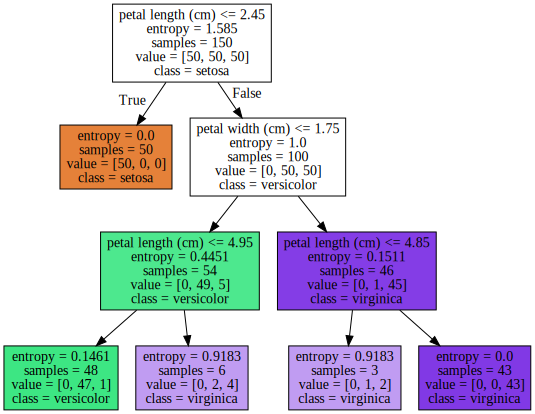

In [49]:
from graphviz import Source
from sklearn.tree import export_graphviz

# export it as .dot file, other common parameters include
# `rounded` (boolean to round the score on each node)
export_graphviz(clf, feature_names = iris.feature_names, filled = True,
                class_names = iris.target_names, out_file = 'tree.dot')

# read it in and visualize it
with open('tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)

In [3]:
target = { 'y': y }
target['y']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [56]:
class Tree:
    
    def __init__(self, regression = False):
        self.regression = regression
        self.is_leaf = False
        
    def train(self, X, target, max_features=None, min_samples_split=10, 
              max_depth=3, minimum_gain=0.01, loss=None):
        
        # Loss for gradient boosting (????)
        if loss is not None:
            self.loss = loss       
        
        try:
            assert max_depth > 0
            assert X.shape[0] > min_samples_split           
        
            if max_features is None:
                max_features = X.shape[1]

            column, value, gain = self._find_best_split(X, target, max_features)
            assert gain > minimum_gain
            
            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # split the dataset and grow left and right child
            left_X, right_X, left_target, right_target = self._split_dataset(X, target, column, value)
            self.left_child = Tree(self.regression)
            self.left_child.train(left_X, left_target, max_features, min_samples_split, max_depth - 1,
                                  minimum_gain, loss)

            self.right_child = Tree(self.regression)
            self.right_child.train(right_X, right_target, max_features, min_samples_split, max_depth - 1,
                                   minimum_gain, loss)
        except AssertionError:
            
            # compute classification probability
            counts = np.bincount(target['y'], minlength = 3)
            prob = counts / target['y'].shape[0]
            self.outcome = prob
            self.is_leaf = True
        
    def _find_best_split(self, X, target, n_features):
        
        # sample random subset of features (replace ??????)
        subset = np.random.choice( X.shape[1], n_features, replace = False )
        parent_entropy = self._compute_entropy(target['y'])
        max_col, max_val, max_gain = None, None, None
        
        for column in subset:
            split_values = self._find_splits(X[:, column])           
            for value in split_values:
                splits = self._split( X[:, column], target['y'], value )
                gain = parent_entropy - self._compute_splits_entropy(target['y'], splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
                
        return max_col, max_val, max_gain
        
    def _find_splits(self, X):
        """find all possible split values"""
        X_unique = np.unique(X)
        split_values = np.empty(X_unique.shape[0] - 1)
        
        for i in range( 1, X_unique.shape[0] ):
            average = ( X_unique[i - 1] + X_unique[i] ) / 2
            split_values[i - 1] = average
        
        return split_values
    
    def _split(self, X, y, value):
        left_mask = X <= value
        right_mask = X > value
        return y[left_mask], y[right_mask]
    
    def _compute_splits_entropy(self, y, splits):
        splits_entropy = 0
        for split in splits:
            splits_entropy += ( split.shape[0] / y.shape[0] ) * self._compute_entropy(split)

        return splits_entropy
    
    def _compute_entropy(self, split):
        _, counts = np.unique(split, return_counts = True)
        p = counts / split.shape[0]
        entropy = -np.sum( p * np.log2(p) ) 
        return entropy
    
    def _split_dataset(self, X, target, column, value, return_X = True):
        left_mask, right_mask = self._get_split_mask(X, column, value)
        
        # ??? why need it as a dict
        # ??? remove the return X
        left, right = {}, {}
        for key in target:
            left[key] = target[key][left_mask]
            right[key] = target[key][right_mask]

        if return_X:
            left_X, right_X = X[left_mask], X[right_mask]
            return left_X, right_X, left, right
        else:
            return left, right
        
    def _get_split_mask(self, X, column, value):
        left_mask = X[:, column] <= value
        right_mask = X[:, column] > value
        return left_mask, right_mask
    
    def predict(self, X):
        proba = self.predict_proba(X)
        pred = np.amax(proba, axis = 1)
        return pred

    def predict_proba(self, X):
        proba = np.empty(( X.shape[0], 3 ))
        for i in range(X.shape[0]):
            proba[i] = self._predict_row(X[i, :])
        
        return proba
    
    def _predict_row(self, row):
        """Predict single row"""
        if not self.is_leaf:
            if row[self.column_index] <= self.threshold:
                return self.left_child._predict_row(row)
            else:
                return self.right_child._predict_row(row)
        
        return self.outcome

In [57]:
test = Tree()
test.train(X, target)
pred = test.predict(X)
accuracy_score(y, y_pred)

0.97333333333333338

In [ ]:
test.feature_importance